In [34]:
from sklearn import manifold
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [68]:
df0 = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME/devchau.csv')
df1 = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME/devchau_bor.csv')
df2 = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME/ericmayer.csv')
df3 = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME/brendanvote.csv')

We want to classify the doctors to see if there is any difference in interval pattern. We'll label the Devinder, Eric and Launceston data as 0, 1 and 2, respectively. Let's import these datasets now.

In [69]:
class ImportClean:
    
    def __init__(self, df):
        self.df = df
        
    def clean(self):
        cdf = self.df
        cdf.CreatedDate = pd.to_datetime(cdf.CreatedDate)
        try:
            cdf.drop(columns=['Unnamed: 0'], inplace=True)
        except:
            pass
        return cdf
    
    def interval_column(self):
        df = self.clean()
        id_list = df.id.unique()
        df.CreatedDate = pd.to_datetime(df.CreatedDate)
        frames = []
        for eye in id_list:
            interval_list = [0]
            pdf = df[df.id == eye]
            pdf.sort_values(by=['CreatedDate'], inplace=True)
            for i in range(len(pdf)-1):
                interval = np.round((pdf.CreatedDate.iloc[i+1] - pdf.CreatedDate.iloc[i]).days / 7)
                interval_list.append(interval)
            pdf['Interval'] = interval_list
            frames.append(pdf)
        return pd.concat(frames)

Again, we'll use the `ImportClean` class to clean the data, and append a column that tells us the interval.

In [70]:
df_list = [df0, df1, df2, df3]
new_list = []
for df in df_list:
    df = ImportClean(df)
    df = df.interval_column()
    new_list.append(df)

In [71]:
new_list[2].head()

,Unnamed: 0.1,Unnamed: 0.1.1,id,CreatedDate,Laterality,visual_acuity,InjToday,InjNext,NextInt,Unnamed: 7,Unnamed: 8,Interval
0,0,0,0,2016-10-18,Left,89.0,NaN,NaN,NaN,NaN,NaN,0.0
1,1,1,0,2017-01-24,Left,94.0,NaN,NaN,NaN,NaN,NaN,14.0
2,2,2,0,2017-07-17,Left,89.0,NaN,NaN,NaN,NaN,NaN,25.0
3,3,3,0,2018-06-14,Left,89.0,NaN,NaN,NaN,NaN,NaN,47.0
4,4,4,0,2019-02-07,Left,94.0,NaN,NaN,NaN,NaN,NaN,34.0


Our next step is to generate our values, which in this case are the interval length time series, one for each patient. We will extract only 10 visits, for only those patients who have actually had 10 visits. Let's write a function to do this. If we have $n$ patients, then the shape of `interval_values` will be $(n, 10)$.

In [72]:
def interval_values(df, length):
    id_list = df.id.unique()
    initial_list = [x for x in range(length)]
    int_values = np.array([initial_list])
    for eye in id_list:
        pdf = df[df.id == eye]
        pdf.CreatedDate = pd.to_datetime(pdf.CreatedDate)
        pdf.sort_values(by=['CreatedDate'])
        pdf.dropna(subset=['Interval'], inplace=True)
        if len(pdf) >= length:
            int_lst = pdf.Interval.to_list()
            int_values = np.vstack((int_values, int_lst[0:length]))
    return int_values[1:, :]

In [73]:
int_values0 = interval_values(new_list[0], 5)
int_values0.shape

(93, 5)

In [74]:
int_values1 = interval_values(new_list[1], 5)
int_values1.shape

(150, 5)

In [75]:
int_values2 = interval_values(new_list[2], 5)
int_values2.shape

(68, 5)

In [76]:
int_values3 = interval_values(new_list[3], 5)
int_values3.shape

(126, 5)

We'll combine all the `int_values` into one numpy array.

In [77]:
int_values = np.vstack((int_values0, int_values1, int_values2, int_values3))
int_values.shape

(437, 5)

We now need to generate our targets. Looking at the shape of our values above, we have the following targets.

In [84]:
targets0 = [0 for x in range(int_values0.shape[0])]
targets1 = [1 for x in range(int_values1.shape[0])]
targets2 = [2 for x in range(int_values2.shape[0])]
targets3 = [3 for x in range(int_values3.shape[0])]
targets = np.append(targets0, targets1)
targets = np.append(targets, targets2)
targets = np.append(targets, targets3)
targets.shape

(437,)

We now use the sklearn built-in `manifold` to create the object.

In [93]:
tsne = manifold.TSNE(n_components=2, random_state=42, perplexity=10, n_iter=5000)
transformed_data = tsne.fit_transform(int_values)

Here, we are creating the pandas dataframe from a numpy array. `x` and `y` are the two components from the t-SNE decomposition, and targets is the actual number of the image.

In [94]:
tsne_df = pd.DataFrame(
    np.column_stack((transformed_data, targets[:3000])),
    columns = ["x", "y", "targets"])
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)

In [95]:
tsne_df.head()

,x,y,targets
0,-3.338449,-4.102638,0
1,82.554863,23.652966,0
2,83.821701,22.605717,0
3,75.140129,-20.504799,0
4,76.694427,-20.641220,0


Finally, we can plot the decomposition.

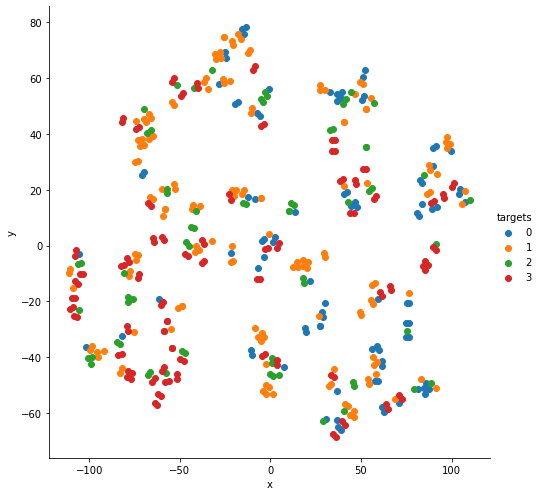

In [96]:
grid = sns.FacetGrid(tsne_df, hue='targets', height=7)
grid.map(plt.scatter, "x", "y").add_legend();